# Time Series Prediction with Prophet 

## By: Jeff Hale

## Plan

### Explore the Prophet time series prediction library with several data sets to see how it performs with different parameters.

## Background
SARIMA and exponential smoothing (Holt Winters) are proven to work well for a range of time series prediction problems, but they require a good bit of parameter tuning. 

Prophet is a relatively new library -  it was released in 2017. It's designed for "Business Time Series".  Prophet is open source and was developed by Facebook. Facebook claims to use it a good deal internally. It is useful for univariate prediction. Prophet has APIs for Python and R. It is designed to be robust to use and to handle seasonal trends and holidays well. 

Prophet uses a generalized additive model, a type of regression model, to make predictions. It can accomodate non-linear smoothers applied ot the regressors. The model is decomposable into trend, seasonality, and holiday components. Prophet is curve-fitting instead of a model class like ARIMA that explicitly accounts for the temporal component of the model through autoregression. 

Prophet can accomodate expert information, so it's Bayesian-friendly.

Prophet is fast and the [Prohpet docs](https://facebook.github.io/prophet/docs/quick_start.html) are quite nice. Here's an [introductory paper](https://peerj.com/preprints/3190/) on the library. 

I've only found two evaluations of Prophet. One, discussed [here],(http://kourentzes.com/forecasting/2017/07/29/benchmarking-facebooks-prophet/) found it didn't perform fabulously with a relatively small amout of data, which isn't shocking. A [second analysis](https://pythondata.com/stock-market-forecasting-with-prophet/) of stock data also didn't find it to perform super well.

We're going to test it on two classic data sets for business-case type problems. 

## Set-up
Load the necessary libraries.
Configure the Jupyter Notebook settings.
Load the data into a pandas DataFrame

In [1]:
# essentials
import numpy as np 
import pandas as pd 

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# time series algorithm
from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics

# reproducibility
np.random.seed(34)

# Jupyter magic
%reload_ext autoreload
%autoreload 2
%matplotlib inline

sns.set()

In [2]:
!ls              # list the file in the working directory

flights                           time_series_prophet-Copy2.ipynb
shampoo                           time_series_prophet-Copy3.ipynb
time_series_benchmark-Copy1.ipynb time_series_prophet.ipynb
time_series_prophet-Copy1.ipynb


# Shampoo Sales

The first dataset is for shampoo sales. Available at [DataMarket](https://datamarket.com/data/set/22r0/sales-of-shampoo-over-a-three-year-period#!ds=22r0&display=line), original dataset Makridakis, Wheelwright, and Hyndman (1998). Hyndman, R.J. “Time Series Data Library”, https://datamarket.com/data/list/?q=provider:tsdl. Accessed on 12/12/18.

This dataset contains monthly data over 3 years for shampoo sales. So 36 observations total.

I found these datasets through Jason Brownlee's [Machine Learning Mastery](https://machinelearningmastery.com).

In [3]:
# !pip list      # list the package version numbers for reproducibiity

We need to skip the header row and exclude the text at the bottom of the .csv file. 

Prophet requires the date column to be labeled *ds* and the target column to be labeled *y*. 

The date column isn't a standard format Pandas will be able to convert, so we'll need to make a date custom parser. We'll do that in a bit.

In [4]:
df_shampoo_orig = pd.read_csv('shampoo/shampoo_sales.csv', 
                              nrows=36,
                              skiprows = 1, 
                              names = ['ds', 'y'], 
                              parse_dates = True )
df = df_shampoo_orig
df

,ds,y
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3
5,1-06,168.5
6,1-07,231.8
7,1-08,224.5
8,1-09,192.8
9,1-10,122.9


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
ds    36 non-null object
y     36 non-null float64
dtypes: float64(1), object(1)
memory usage: 656.0+ bytes


Let's get the *ds* column into datatime format.

In [6]:
df['ds'] = df.ds.apply(lambda x: "198"+x)
df.ds.head()

0    1981-01
1    1981-02
2    1981-03
3    1981-04
4    1981-05
Name: ds, dtype: object

### tseries.offset.MonthEnd(0)
This next cell uses the awesome tseries.offset.MonthEnd(0) method to make the day of the month the final day. This is necessary for Prophet to make the predictions we need at the correctly spaced monthly intervals.

In [7]:
df['ds']=pd.to_datetime(df['ds'])+pd.tseries.offsets.MonthEnd(0)

In [8]:
df.head()

,ds,y
0,1981-01-31,266.0
1,1981-02-28,145.9
2,1981-03-31,183.1
3,1981-04-30,119.3
4,1981-05-31,180.3


That looks better.

## Prophet forecast

We need to make a dataframe of future dates with the *.make_future_dataframe* method. Let's make 12 months worth of predictions.

In [9]:
train = df[:24]
train.tail()

,ds,y
19,1982-08-31,303.6
20,1982-09-30,289.9
21,1982-10-31,421.6
22,1982-11-30,264.5
23,1982-12-31,342.3


Let's instantiate a Prophet object and fit it to the training data.

Prophet tries to model daily and weekly seasonality by default. We'll define our own yearly seasonal pattern. 

"Seasonalities are estimated using a partial Fourier sum... a partial Fourier sum can approximate an aribtrary periodic signal. The number of terms in the partial sum (the order) is a parameter that determines how quickly the seasonality can change." - from the [docs](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html).

We'll try a Fourier sum of 5 to start and then adjust to see the effects.

We need to pass a n_changepoints parameter because the datset has < 25 observations, as discussedi n [this GitHub issue](https://github.com/facebook/prophet/issues/248#issuecomment-314624770).

In [10]:
m = Prophet(weekly_seasonality=False, daily_seasonality=False, n_changepoints=2)
m.add_seasonality(name='yearly', period=12, fourier_order=5)
m.fit(train)

INFO:fbprophet.forecaster:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
/Users/jeffhale/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Let's make the future data frame and make the predictions. We need to pass *freq='m'* because we want monthly predictions.

In [11]:
future = m.make_future_dataframe(periods=12, freq='M')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,1981-01-31,208.729241,169.067463,249.800180
1,1981-02-28,138.435840,95.973782,179.567915
2,1981-03-31,195.953126,154.777382,236.933127
3,1981-04-30,129.305533,88.577825,168.846170
4,1981-05-31,230.795968,193.623741,275.871089
5,1981-06-30,158.016534,117.154671,199.449109
6,1981-07-31,234.337810,195.574922,273.893274
7,1981-08-31,200.058452,159.366761,238.844769
8,1981-09-30,268.403370,226.696131,306.001430
9,1981-10-31,127.519215,86.889810,166.787652


Note that Prophet's make_future_dataframe method makes a DataFrame that includes the historical data, as well as the predictions. 

The predictions look reasonable at first glance. Let's make at a plot.

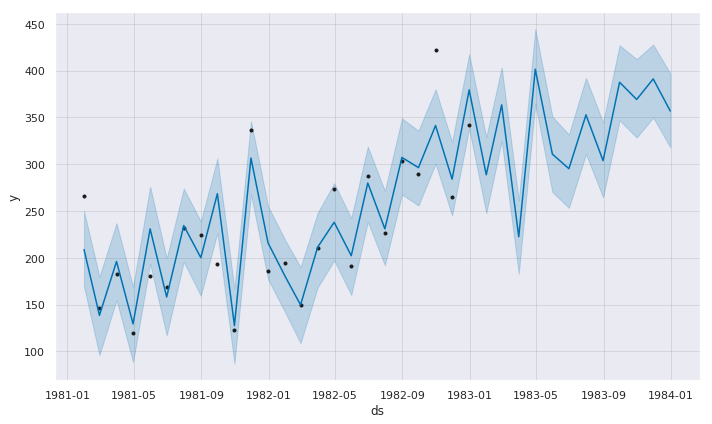

In [12]:
figure = m.plot(forecast)

The dots are the actual data points. The line through the dots is the predicted values. The shared area represents the uncertainty intervals. 

Let's decompose this graph into the trend and seasonality.

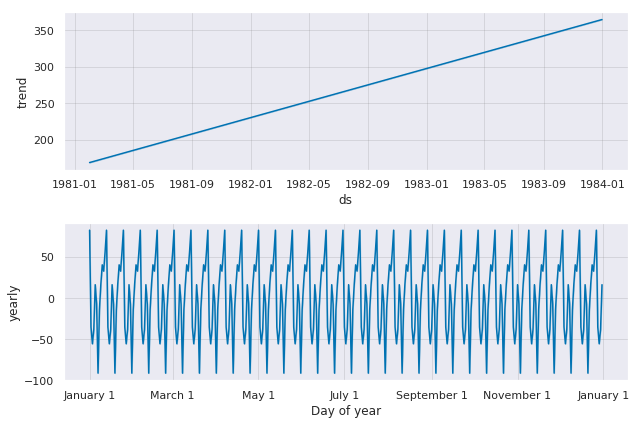

In [13]:
fig_decompose = m.plot_components(forecast)

The trend line looks correct. But the seasonality looks like it might be over-fitting.

### Reduce fourier_order
Let's see what happens if we reduce the *fourier_order* to 1.

In [14]:
m2 = Prophet(weekly_seasonality=False, daily_seasonality=False, n_changepoints=2)
m2.add_seasonality(name='yearly', period=12, fourier_order=1)

m2.fit(train)
future2 = m2.make_future_dataframe(periods=12, freq='m')
forecast2 = m2.predict(future2)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet.forecaster:Found custom seasonality named "yearly", disabling built-in yearly seasonality.


,ds,yhat,yhat_lower,yhat_upper
31,1983-08-31,329.262238,271.236077,378.059778
32,1983-09-30,425.071544,370.077028,480.042584
33,1983-10-31,333.588711,276.343760,389.293695
34,1983-11-30,450.692537,392.893193,509.692437
35,1983-12-31,352.617516,298.100596,410.110262


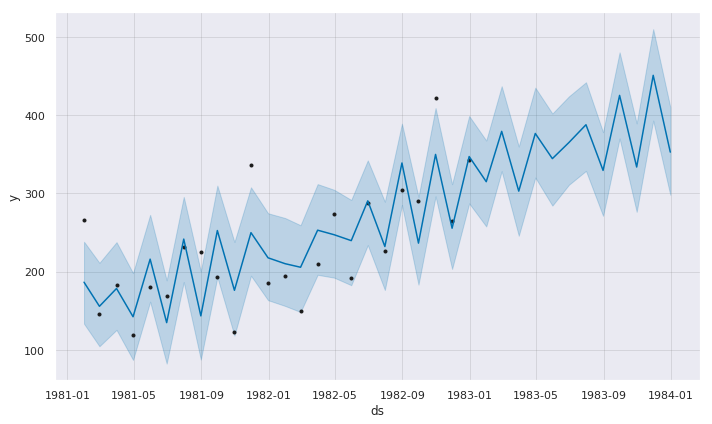

In [15]:
fig2 = m2.plot(forecast2)

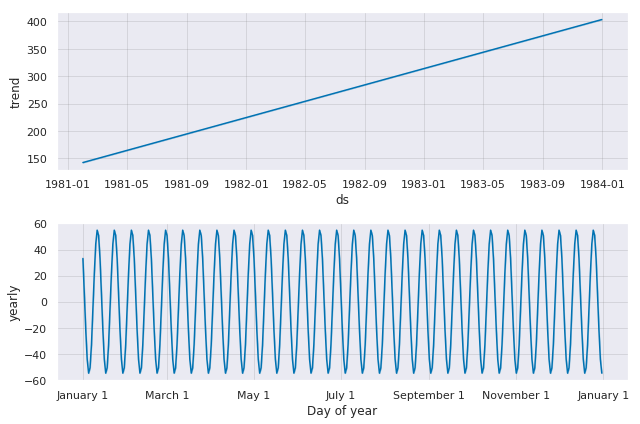

In [16]:
fig2_decompose = m2.plot_components(forecast2)

Looks fairly similar, with a bit less over-fitting to the seasonality.

## Performance metrics

Let's compare the predictions to the actual values from the first forecast, when the fourier_term was higher and nothing was log transformed. 

We first need to create a cutoff column so Prophet knows when to compare predicted values to actual values.

In [17]:
forecast['cutoff'] = pd.to_datetime('1980-12-31')
forecast['y'] = df['y']
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,cutoff,y
31,1983-08-31,341.855874,264.578271,344.649028,341.855873,341.855875,-38.198942,-38.198942,-38.198942,-38.198942,-38.198942,-38.198942,0.0,0.0,0.0,303.656933,1980-12-31,407.6
32,1983-09-30,347.372556,346.791660,426.914281,347.372555,347.372557,40.097173,40.097173,40.097173,40.097173,40.097173,40.097173,0.0,0.0,0.0,387.469730,1980-12-31,682.0
33,1983-10-31,353.073127,328.338425,412.267218,353.073126,353.073129,15.984919,15.984919,15.984919,15.984919,15.984919,15.984919,0.0,0.0,0.0,369.058046,1980-12-31,475.3
34,1983-11-30,358.589809,349.804113,427.688775,358.589807,358.589811,32.421763,32.421763,32.421763,32.421763,32.421763,32.421763,0.0,0.0,0.0,391.011573,1980-12-31,581.3
35,1983-12-31,364.290380,317.936257,396.973959,364.290378,364.290383,-7.558167,-7.558167,-7.558167,-7.558167,-7.558167,-7.558167,0.0,0.0,0.0,356.732214,1980-12-31,646.9


In [18]:
df_p = performance_metrics(forecast)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
2,90 days,1166.952133,34.160681,25.862682,0.112220,0.666667
3,120 days,107.009070,10.344519,10.107606,0.068408,1.000000
4,151 days,938.385424,30.633077,24.451542,0.144711,0.666667
5,181 days,919.952161,30.330713,23.661655,0.142050,0.666667
6,212 days,888.728760,29.811554,21.172415,0.117744,0.666667


Ok. Prophet is giving us a row of error terms for a variety of time windows into the future.  Let's see how these error values compare to the predictions with the lower Fourier term.

In [19]:
forecast2['cutoff'] = pd.to_datetime('1980-12-31')
forecast2['y'] = df['y']
forecast2.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,cutoff,y
31,1983-08-31,373.484825,271.236077,378.059778,373.484820,373.484829,-44.222588,-44.222588,-44.222588,-44.222588,-44.222588,-44.222588,0.0,0.0,0.0,329.262238,1980-12-31,407.6
32,1983-09-30,380.848956,370.077028,480.042584,380.848951,380.848962,44.222588,44.222588,44.222588,44.222588,44.222588,44.222588,0.0,0.0,0.0,425.071544,1980-12-31,682.0
33,1983-10-31,388.458559,276.343760,389.293695,388.458552,388.458565,-54.869847,-54.869847,-54.869847,-54.869847,-54.869847,-54.869847,0.0,0.0,0.0,333.588711,1980-12-31,475.3
34,1983-11-30,395.822690,392.893193,509.692437,395.822681,395.822698,54.869847,54.869847,54.869847,54.869847,54.869847,54.869847,0.0,0.0,0.0,450.692537,1980-12-31,581.3
35,1983-12-31,403.432292,298.100596,410.110262,403.432282,403.432302,-50.814776,-50.814776,-50.814776,-50.814776,-50.814776,-50.814776,0.0,0.0,0.0,352.617516,1980-12-31,646.9


In [20]:
df_p2 = performance_metrics(forecast2)
df_p2.head()

,horizon,mse,rmse,mae,mape,coverage
2,90 days,2147.441941,46.340500,31.327653,0.130532,0.666667
3,120 days,216.739121,14.722062,12.509595,0.095340,1.000000
4,151 days,607.788914,24.653375,21.114171,0.138785,1.000000
5,181 days,978.071084,31.274128,30.784388,0.196907,1.000000
6,212 days,832.325625,28.850054,26.344087,0.146464,1.000000


Let's make a DataFrame that subtracts the error terms from the first predictions from the second predictions so that we can see which version predicted better. We'll make the horizons into indexes for legibility.

In [21]:
df_p.index = df_p['horizon']
df_p2.index = df_p2['horizon']

df_error_compare = df_p - df_p2
df_error_compare = df_error_compare.drop(columns=['horizon', 'coverage'])
df_error_compare.loc[:'365 days']

,mse,rmse,mae,mape
horizon,,,,
90 days,-980.489808,-12.179819,-5.464971,-0.018312
120 days,-109.730051,-4.377544,-2.401989,-0.026932
151 days,330.596510,5.979702,3.337371,0.005926
181 days,-58.118924,-0.943415,-7.122732,-0.054856
212 days,56.403135,0.961500,-5.171672,-0.028720
243 days,-2359.529498,-35.540728,-28.987673,-0.140216
273 days,-1300.246041,-12.470560,-15.954056,-0.066838
304 days,-2207.735256,-19.769723,-29.750106,-0.188283
334 days,-2425.376712,-21.063721,-29.791646,-0.160444


Mostly we see negative numbers, which means that the second model with the Fourier term equal to 1 had larger error terms. So, in this case, the larger Fourier term model performed better.

Let's see how our second Prophet model forecast compared to a persistence forecast. A persistence forecast means a prediction that the final sales term in the training data would continue each month going forward. We'll make a DataFrame with a persistence forecast prediction.

In [22]:
forecast_persist = forecast2.copy()
forecast_persist['cutoff'] = pd.to_datetime('1980-12-31')
forecast_persist['y'] = df['y']
forecast_persist['yhat'] = df.at[23,'y']
forecast_persist.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,cutoff,y
31,1983-08-31,373.484825,271.236077,378.059778,373.484820,373.484829,-44.222588,-44.222588,-44.222588,-44.222588,-44.222588,-44.222588,0.0,0.0,0.0,342.3,1980-12-31,407.6
32,1983-09-30,380.848956,370.077028,480.042584,380.848951,380.848962,44.222588,44.222588,44.222588,44.222588,44.222588,44.222588,0.0,0.0,0.0,342.3,1980-12-31,682.0
33,1983-10-31,388.458559,276.343760,389.293695,388.458552,388.458565,-54.869847,-54.869847,-54.869847,-54.869847,-54.869847,-54.869847,0.0,0.0,0.0,342.3,1980-12-31,475.3
34,1983-11-30,395.822690,392.893193,509.692437,395.822681,395.822698,54.869847,54.869847,54.869847,54.869847,54.869847,54.869847,0.0,0.0,0.0,342.3,1980-12-31,581.3
35,1983-12-31,403.432292,298.100596,410.110262,403.432282,403.432302,-50.814776,-50.814776,-50.814776,-50.814776,-50.814776,-50.814776,0.0,0.0,0.0,342.3,1980-12-31,646.9


Now let's compare the persistence forecast to the actual results.

In [23]:
df_persist = performance_metrics(forecast_persist)
df_persist.head()

,horizon,mse,rmse,mae,mape,coverage
2,90 days,23246.430000,152.467800,143.966667,0.834147,0.666667
3,120 days,37882.200000,194.633502,192.866667,1.361612,1.000000
4,151 days,33772.546667,183.773085,181.400000,1.212403,1.000000
5,181 days,35393.146667,188.130664,186.266667,1.266398,1.000000
6,212 days,22886.896667,151.284159,148.766667,0.802220,1.000000


Now let's compute the difference between the persistence forecast error terms and the second Prophet model.

In [24]:
df_persist.index = df_persist['horizon']

df_error_compare_persist = df_persist - df_p2
df_error_compare_persist = df_error_compare_persist.drop(columns=['horizon', 'coverage'])
df_error_compare_persist.loc[:'365 days']

,mse,rmse,mae,mape
horizon,,,,
90 days,21098.988059,106.127300,112.639014,0.703615
120 days,37665.460879,179.911439,180.357072,1.266272
151 days,33164.757752,159.119709,160.285829,1.073619
181 days,34415.075583,156.856536,155.482279,1.069491
212 days,22054.571041,122.434105,122.422580,0.655756
243 days,16167.069559,86.018522,92.558052,0.476732
273 days,12738.967528,68.698140,75.785035,0.354791
304 days,23801.882758,101.972487,97.595182,0.660629
334 days,18868.563573,85.214880,58.360703,0.525859


Those numbers are all positive, meaning that the error terms were larger for the persistence model than for the Prophet model! Granted, this is a very small sample with a clear trend, but Prophet beat the baseline. That's good. Let's try another prediction problem.

# Airline Passenger Counts

The second dataset is for International airline passengers: monthly totals in thousands. Jan 49 – Dec 60 Available at [DataMarket](http://datamarket.com/data/list/?q=provider:tsdl), original dataset Source: Box & Jenkins (1976). Accessed on 12/16/18.

In [25]:
df_air_orig = pd.read_csv('flights/international-airline-passengers.csv', 
                              nrows=144,
                              skiprows = 1, 
                              names = ['ds', 'y'], 
                              parse_dates = True )
df_air = df_air_orig
df_air.head()

,ds,y
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [26]:
df_air.tail()

,ds,y
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


In [27]:
df_air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
ds    144 non-null object
y     144 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.3+ KB


No nulls. That's good. Looks like we need to parse the dates again.

In [28]:
df_air['ds']=pd.to_datetime(df_air['ds'])+pd.tseries.offsets.MonthEnd(0)

In [29]:
df_air.head()

,ds,y
0,1949-01-31,112
1,1949-02-28,118
2,1949-03-31,132
3,1949-04-30,129
4,1949-05-31,121


In [30]:
df_air.tail()

,ds,y
139,1960-08-31,606
140,1960-09-30,508
141,1960-10-31,461
142,1960-11-30,390
143,1960-12-31,432


That all looks correct.

In [31]:
df_air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
ds    144 non-null datetime64[ns]
y     144 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.3 KB


Ok. Now we're flying. Ha! Groan. We need to decide what time period we want to forecast. Let's forecast the last two years. 

Let's fit a Prophet model with the training data.

In [32]:
train = df_air[:120]

Let's instantiate a Prophet object and fit it to the training data. Unlike the shampoo sales data, this time we're going to use the default Prophet parameters.

In [33]:
m = Prophet()
m.fit(train)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/jeffhale/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Let's make the future data frame and make the predictions. We need to pass *freq='m'* because we want monthly predictions.

In [34]:
future = m.make_future_dataframe(periods=24, freq='m')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,1949-01-31,87.214860,63.560628,109.066644
1,1949-02-28,84.831906,59.688565,107.843078
2,1949-03-31,117.079406,92.537445,141.218207
3,1949-04-30,109.717180,86.855929,132.619914
4,1949-05-31,111.031962,85.409482,134.338681


In [35]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
139,1960-08-31,521.719176,496.084883,546.378707
140,1960-09-30,481.912234,458.777726,506.900663
141,1960-10-31,449.437125,424.853684,474.635358
142,1960-11-30,421.078685,397.614441,445.161279
143,1960-12-31,446.890075,423.156988,471.890762


That data looks reasonable at first glance. Let's make at a plot.

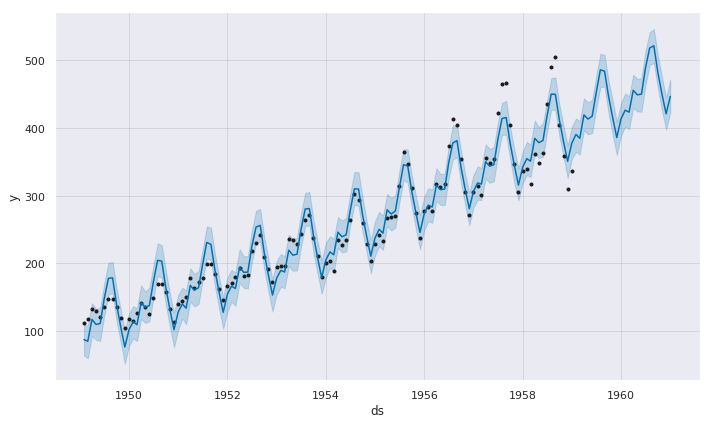

In [36]:
fig = m.plot(forecast)

Again, the dots are the actual data points. The line through the dots is the predicted values. The shared area represents the uncertainty intervals. 

Let's decompose this graph into the trend and seasonality. Before making any adjustments to the model.

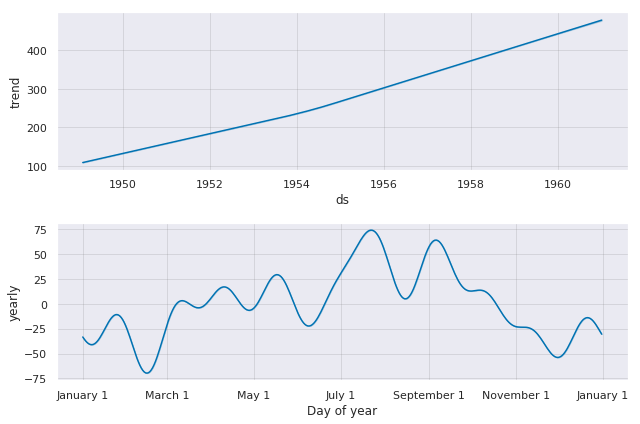

In [37]:
fig_decompose = m.plot_components(forecast)

In [38]:
## Multiplicative seasonality

It looks like the latter seasonal high and low data points in the training data weren't picked up super well. Perhpas we should try making that seasonality effect multiplicative. 

So this is funny, I went to the docs to see how to add multiplicative seasonality and found a chart much like the one above. Turns out the Prophet team used this dataset as an example for multiplicative seasonality! Guess my instinct was right :) 

In [39]:
m2 = Prophet(seasonality_mode='multiplicative')
m2.fit(train)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [40]:
future2 = m2.make_future_dataframe(periods=24, freq='m')
forecast = m2.predict(future2)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,1949-01-31,103.725100,91.886616,114.456737
1,1949-02-28,102.761103,91.061854,113.862417
2,1949-03-31,119.421970,107.689470,132.045182
3,1949-04-30,116.806271,105.379000,128.659171
4,1949-05-31,118.934286,106.690761,130.857089


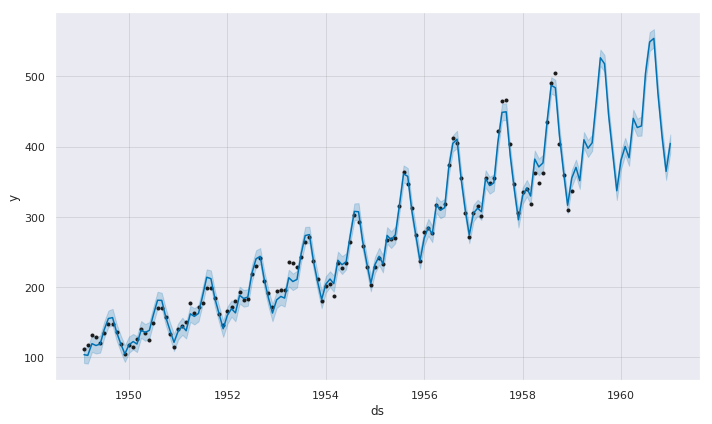

In [41]:
fig = m.plot(forecast)

That looks much better!

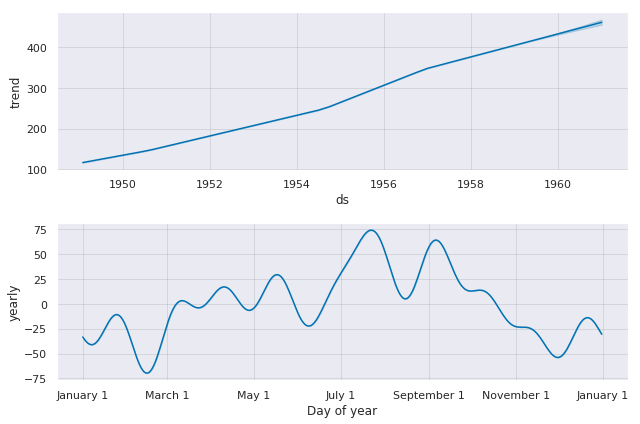

In [42]:
fig = m.plot_components(forecast)

Looks like people travel in the summer.

## Model evaluation

Let's look at how the model with the multiplicative seasonality effect performs compared to a persistence model.

First we'll make a persistence model DataFrame.

In [43]:
forecast_persist = forecast.copy()
forecast_persist['cutoff'] = pd.to_datetime('1959-01')
forecast_persist['y'] = df_air['y']
forecast_persist['yhat'] = df_air.at[119,'y']
forecast_persist.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,cutoff,y
139,1960-08-31,451.826514,541.351438,567.419568,447.287484,456.698366,0.226575,0.226575,0.226575,0.226575,0.226575,0.226575,0.0,0.0,0.0,337,1959-01-01,606
140,1960-09-30,454.151961,463.941071,490.064953,449.190264,459.605067,0.050257,0.050257,0.050257,0.050257,0.050257,0.050257,0.0,0.0,0.0,337,1959-01-01,508
141,1960-10-31,456.554923,400.515967,427.439523,451.336351,462.388252,-0.091344,-0.091344,-0.091344,-0.091344,-0.091344,-0.091344,0.0,0.0,0.0,337,1959-01-01,461
142,1960-11-30,458.880371,352.601063,377.847268,453.228286,465.150886,-0.204916,-0.204916,-0.204916,-0.204916,-0.204916,-0.204916,0.0,0.0,0.0,337,1959-01-01,390
143,1960-12-31,461.283333,391.372787,417.280235,455.194125,468.105984,-0.122916,-0.122916,-0.122916,-0.122916,-0.122916,-0.122916,0.0,0.0,0.0,337,1959-01-01,432


Here's what the persistence forecast looks like graphically.

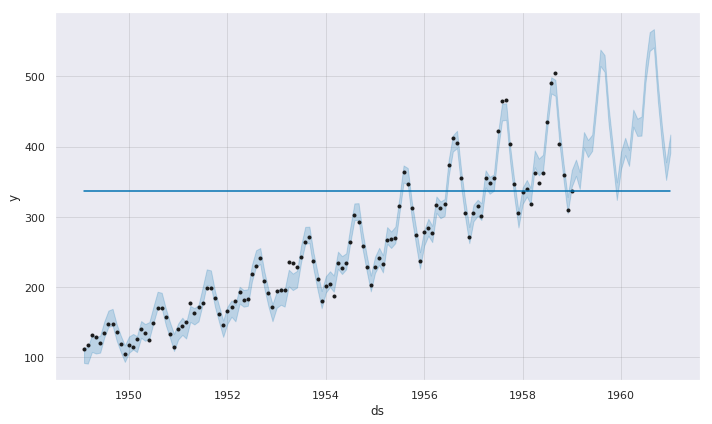

In [44]:
fig = m.plot(forecast_persist)

The straight line is the persistence forecast based on the value at the last training month, December 1958. The predicted range of values for the Prophet model is in the shaded region.

Ok. Now we need to add the *cutoff* and *y* values to the forecast.

In [45]:
forecast['cutoff'] = pd.to_datetime('1958-12-31')
forecast['y'] = df_air['y']
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,cutoff,y
139,1960-08-31,451.826514,541.351438,567.419568,447.287484,456.698366,0.226575,0.226575,0.226575,0.226575,0.226575,0.226575,0.0,0.0,0.0,554.199043,1958-12-31,606
140,1960-09-30,454.151961,463.941071,490.064953,449.190264,459.605067,0.050257,0.050257,0.050257,0.050257,0.050257,0.050257,0.0,0.0,0.0,476.976416,1958-12-31,508
141,1960-10-31,456.554923,400.515967,427.439523,451.336351,462.388252,-0.091344,-0.091344,-0.091344,-0.091344,-0.091344,-0.091344,0.0,0.0,0.0,414.851550,1958-12-31,461
142,1960-11-30,458.880371,352.601063,377.847268,453.228286,465.150886,-0.204916,-0.204916,-0.204916,-0.204916,-0.204916,-0.204916,0.0,0.0,0.0,364.848359,1958-12-31,390
143,1960-12-31,461.283333,391.372787,417.280235,455.194125,468.105984,-0.122916,-0.122916,-0.122916,-0.122916,-0.122916,-0.122916,0.0,0.0,0.0,404.584234,1958-12-31,432


Looks good. Now we need to compute the error terms for both models.

In [46]:
df_air_p = performance_metrics(forecast[120:])
df_air_p.head()

,horizon,mse,rmse,mae,mape,coverage
121,59 days,100.689922,10.034437,10.023238,0.028540,1.0
122,90 days,52.896318,7.272986,6.685387,0.018667,1.0
123,120 days,8.859151,2.976433,2.793146,0.006935,1.0
124,151 days,107.241253,10.355735,8.151652,0.019536,0.5
125,181 days,141.862040,11.910585,11.522369,0.026319,0.5


In [47]:
df_persist_p = performance_metrics(forecast_persist[120:])
df_persist_p.head()

,horizon,mse,rmse,mae,mape,coverage
121,58 days,277.0,16.643317,14.0,0.039254,1.0
122,89 days,2393.0,48.918299,37.0,0.092285,1.0
123,119 days,4121.0,64.195015,64.0,0.159470,1.0
124,150 days,5185.0,72.006944,71.0,0.173304,0.5
125,180 days,12557.0,112.058021,109.0,0.241818,0.5


Let's plot the RMSE lines for the two models. I chose RMSE because its a common metric that outputs an error term in the same units as the predicted variable. So in this case, passengers.

In [48]:
df_air_plot = pd.DataFrame([df_air_p['rmse'], df_persist_p['rmse']])
df_air_plot = df_air_plot.T
df_air_plot.columns = ['prophet_rmse', 'persist_rmse']
df_air_plot.head()

,prophet_rmse,persist_rmse
121,10.034437,16.643317
122,7.272986,48.918299
123,2.976433,64.195015
124,10.355735,72.006944
125,11.910585,112.058021


In [49]:
df_plot = df_air_plot[:12]
df_plot

,prophet_rmse,persist_rmse
121,10.034437,16.643317
122,7.272986,48.918299
123,2.976433,64.195015
124,10.355735,72.006944
125,11.910585,112.058021
126,16.273896,177.124250
127,32.651458,216.569850
128,31.489985,180.499307
129,17.160150,101.921538
130,21.162583,52.559490


Text(0, 0.5, 'RMSE')

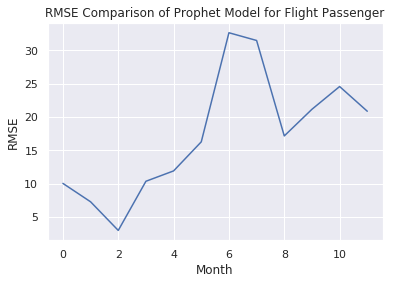

In [50]:
ax = sns.lineplot(
    data=df_plot,
    x=list(range(12)), 
    y='prophet_rmse',
    )
plt.title('RMSE Comparison of Prophet Model for Flight Passenger')
plt.xlabel('Month')
plt.ylabel('RMSE')

Let's add the persistence line and clean things up a bit.

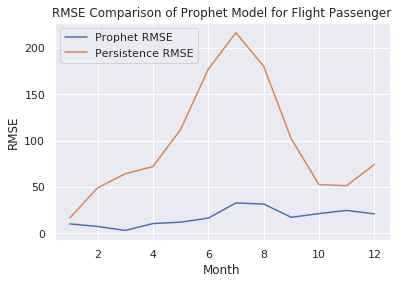

In [51]:
ax = sns.lineplot(
    data=df_plot,
    x=list(range(1, 13)), 
    y='prophet_rmse',
    )

ax = sns.lineplot(
    data=df_plot,
    x=list(range(1, 13)), 
    y='persist_rmse',
    )

plt.title('RMSE Comparison of Prophet Model for Flight Passenger')
plt.xlabel('Month')
plt.ylabel('RMSE')

plt.rcParams['figure.figsize']=(12, 6)
plt.legend(['Prophet RMSE','Persistence RMSE'])

The Persistence model has a higher RMSE for every time period. So Prophet beats the Persistence model! That's a low bar, but we'll take it - predicting the future isn't easy.

Now we will subtract one DataFrame from the other to see the exact differences in errors.

In [52]:
df_air_compare = df_persist_p - df_air_p

df_air_compare = df_air_compare.drop(columns=['horizon', 'coverage'])

In [53]:
df_air_compare[:12]

,mse,rmse,mae,mape
121,176.310078,6.608880,3.976762,0.010714
122,2340.103682,41.645314,30.314613,0.073618
123,4112.140849,61.218583,61.206854,0.152536
124,5077.758747,61.651209,62.848348,0.153768
125,12415.137960,100.147435,97.477631,0.215499
126,31108.160319,160.850354,158.054322,0.307004
127,45836.382274,183.918392,185.344596,0.334969
128,31588.380874,149.009323,144.757547,0.279069
129,10093.529238,84.761388,80.844602,0.182522
130,2314.645091,31.396907,26.723662,0.065690


Confirming what we saw in our graph, we see that the persistence model had a larger error than the Prophet model for nearly all time periods and nearly all error terms.

## Future directions

It would be interesting to look at Propher performance on more and larger data sets. It would also be cool to compare Prophet with SARIMA and exponential smoothing (Holt-Winters) models. Deep learning models haven't proven especially effective at time series forecasting, but they could be compared also.

Overall, Prophet is fun to work with and Facebook claims to find it quite effective, so it merits further study. 

## If you found this helpful, please upvote [this Kaggle Kernel](https://www.kaggle.com/discdiver/testing-prophet-for-time-series-prediction) so others can find it too.